Improved-LLM-Tutor

In [15]:
# Standard library imports
import os
import time
import json
from typing import Dict, List, Any, Optional, Union, Callable

# Third-party imports
from dotenv import load_dotenv
from IPython.display import Markdown, display, HTML, update_display
from openai import OpenAI
import ollama
import pandas as pd
import matplotlib.pyplot as plt

# Try to import rich, install if not available
try:
    from rich.console import Console
    from rich.markdown import Markdown as RichMarkdown
    from rich.panel import Panel
except ImportError:
    !pip install rich
    from rich.console import Console
    from rich.markdown import Markdown as RichMarkdown
    from rich.panel import Panel


In [16]:

# Constants
MODEL_GPT = 'gpt-4o-mini'
MODEL_LLAMA = 'llama3.2'
DEFAULT_SYSTEM_PROMPT = "You are a helpful technical tutor who answers questions about python code, software engineering, data science and LLMs"

# Set up environment
load_dotenv()
openai = OpenAI()
console = Console()


In [17]:

class LLMTutor:
    """
    A class that provides tutoring functionality using multiple LLM models.
    """
    
    def __init__(self, 
                 system_prompt: str = DEFAULT_SYSTEM_PROMPT,
                 gpt_model: str = MODEL_GPT,
                 llama_model: str = MODEL_LLAMA):
        """
        Initialize the LLM Tutor with specified models and system prompt.
        
        Args:
            system_prompt: The system prompt to use for the LLMs
            gpt_model: The OpenAI GPT model to use
            llama_model: The Ollama model to use
        """
        self.system_prompt = system_prompt
        self.gpt_model = gpt_model
        self.llama_model = llama_model
        self.history: List[Dict[str, Any]] = []
        self.response_times = {'gpt': [], 'llama': []}
        
    def format_question(self, question: str) -> str:
        """
        Format the user's question with a standard prefix.
        
        Args:
            question: The user's question
            
        Returns:
            Formatted question with prefix
        """
        return f"Please give a detailed explanation to the following question: {question}"
    
    def create_messages(self, question: str) -> List[Dict[str, str]]:
        """
        Create the message structure for LLM API calls.
        
        Args:
            question: The user's question
            
        Returns:
            List of message dictionaries
        """
        formatted_question = self.format_question(question)
        return [
            {"role": "system", "content": self.system_prompt},
            {"role": "user", "content": formatted_question}
        ]
    
    def get_gpt_response(self, 
                        question: str, 
                        stream: bool = True) -> str:
        """
        Get a response from the GPT model.
        
        Args:
            question: The user's question
            stream: Whether to stream the response
            
        Returns:
            The model's response as a string
        """
        messages = self.create_messages(question)
        start_time = time.time()
        
        try:
            if stream:
                return self._stream_gpt_response(messages)
            else:
                response = openai.chat.completions.create(
                    model=self.gpt_model, 
                    messages=messages
                )
                elapsed = time.time() - start_time
                self.response_times['gpt'].append(elapsed)
                return response.choices[0].message.content
        except Exception as e:
            console.print(f"[bold red]Error with GPT model:[/bold red] {str(e)}")
            return f"Error: {str(e)}"
    
    def _stream_gpt_response(self, messages: List[Dict[str, str]]) -> str:
        """
        Stream a response from the GPT model.
        
        Args:
            messages: The messages to send to the model
            
        Returns:
            The complete response as a string
        """
        start_time = time.time()
        try:
            stream = openai.chat.completions.create(
                model=self.gpt_model, 
                messages=messages,
                stream=True
            )
            
            response = ""
            display_handle = display(Markdown(""), display_id=True)
            
            for chunk in stream:
                delta_content = chunk.choices[0].delta.content or ''
                response += delta_content
                # Clean the response for display
                clean_response = response.replace("```python", "```").replace("```", "")
                update_display(Markdown(clean_response), display_id=display_handle.display_id)
            
            elapsed = time.time() - start_time
            self.response_times['gpt'].append(elapsed)
            return response
        except Exception as e:
            console.print(f"[bold red]Error streaming GPT response:[/bold red] {str(e)}")
            return f"Error: {str(e)}"
    
    def get_llama_response(self, question: str) -> str:
        """
        Get a response from the Llama model.
        
        Args:
            question: The user's question
            
        Returns:
            The model's response as a string
        """
        messages = self.create_messages(question)
        start_time = time.time()
        
        try:
            response = ollama.chat(model=self.llama_model, messages=messages)
            elapsed = time.time() - start_time
            self.response_times['llama'].append(elapsed)
            return response['message']['content']
        except Exception as e:
            console.print(f"[bold red]Error with Llama model:[/bold red] {str(e)}")
            return f"Error: {str(e)}"
    
    def ask(self, question: str, models: List[str] = ['gpt', 'llama']) -> Dict[str, str]:
        """
        Ask a question to one or more models.
        
        Args:
            question: The user's question
            models: List of models to query ('gpt', 'llama', or both)
            
        Returns:
            Dictionary with model responses
        """
        responses = {}
        
        # Store the question in history
        self.history.append({
            'question': question,
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'responses': {}
        })
        
        # Get responses from requested models
        if 'gpt' in models:
            console.print(Panel(f"[bold blue]Getting response from {self.gpt_model}...[/bold blue]"))
            gpt_response = self.get_gpt_response(question)
            responses['gpt'] = gpt_response
            self.history[-1]['responses']['gpt'] = gpt_response
            
        if 'llama' in models:
            console.print(Panel(f"[bold green]Getting response from {self.llama_model}...[/bold green]"))
            llama_response = self.get_llama_response(question)
            responses['llama'] = llama_response
            self.history[-1]['responses']['llama'] = llama_response
            display(Markdown(f"## {self.llama_model} Response\n{llama_response}"))
            
        return responses
    
    def compare_responses(self, question: str = None) -> None:
        """
        Compare responses from different models side by side.
        
        Args:
            question: Optional specific question to compare responses for
        """
        if question:
            responses = self.ask(question)
        else:
            # Use the most recent question from history
            if not self.history:
                console.print("[bold red]No questions in history to compare[/bold red]")
                return
            responses = self.history[-1]['responses']
            question = self.history[-1]['question']
        
        # Create HTML for side-by-side comparison
        html = f"""
        <div style="display: flex; width: 100%;">
            <div style="flex: 1; padding: 10px; border: 1px solid #ddd; border-radius: 5px; margin-right: 10px;">
                <h3 style="color: #4285F4;">{self.gpt_model}</h3>
                <div style="white-space: pre-wrap;">{responses.get('gpt', 'No response')}</div>
            </div>
            <div style="flex: 1; padding: 10px; border: 1px solid #ddd; border-radius: 5px;">
                <h3 style="color: #34A853;">{self.llama_model}</h3>
                <div style="white-space: pre-wrap;">{responses.get('llama', 'No response')}</div>
            </div>
        </div>
        """
        display(HTML(html))
    
    def show_performance_metrics(self) -> None:
        """
        Display performance metrics for the models.
        """
        if not self.response_times['gpt'] and not self.response_times['llama']:
            console.print("[bold yellow]No performance data available yet[/bold yellow]")
            return
        
        # Create DataFrame for metrics
        data = {
            'Model': [],
            'Response Time (s)': []
        }
        
        for model, times in self.response_times.items():
            for t in times:
                data['Model'].append(model)
                data['Response Time (s)'].append(t)
        
        df = pd.DataFrame(data)
        
        # Calculate statistics
        stats = df.groupby('Model')['Response Time (s)'].agg(['mean', 'min', 'max', 'count'])
        
        # Display statistics
        console.print("\n[bold]Performance Statistics:[/bold]")
        console.print(stats)
        
        # Create visualization
        plt.figure(figsize=(10, 6))
        
        # Box plot
        ax = plt.subplot(1, 2, 1)
        df.boxplot(column='Response Time (s)', by='Model', ax=ax)
        plt.title('Response Time Distribution')
        plt.suptitle('')
        
        # Bar chart for average times
        ax = plt.subplot(1, 2, 2)
        stats['mean'].plot(kind='bar', ax=ax, color=['#4285F4', '#34A853'])
        plt.title('Average Response Time')
        plt.ylabel('Seconds')
        
        plt.tight_layout()
        plt.show()
    
    def save_history(self, filename: str = 'tutor_history.json') -> None:
        """
        Save the question and response history to a file.
        
        Args:
            filename: The filename to save to
        """
        try:
            with open(filename, 'w') as f:
                json.dump(self.history, f, indent=2)
            console.print(f"[bold green]History saved to {filename}[/bold green]")
        except Exception as e:
            console.print(f"[bold red]Error saving history:[/bold red] {str(e)}")
    
    def load_history(self, filename: str = 'tutor_history.json') -> None:
        """
        Load question and response history from a file.
        
        Args:
            filename: The filename to load from
        """
        try:
            with open(filename, 'r') as f:
                self.history = json.load(f)
            console.print(f"[bold green]History loaded from {filename}[/bold green]")
        except FileNotFoundError:
            console.print(f"[bold yellow]History file {filename} not found[/bold yellow]")
        except Exception as e:
            console.print(f"[bold red]Error loading history:[/bold red] {str(e)}")


In [18]:

# Create a tutor instance
tutor = LLMTutor()
console.print("[bold green]LLM Tutor initialized successfully![/bold green]")


LLM Tutor initialized successfully!

In [19]:

# Define your question here
question = """
Given a list of dictionaries called 'books', write code to find and print all information 
about the book titled 'Mastery' by Robert Greene.
"""

console.print(Panel(f"[bold]Question:[/bold]\n{question}", border_style="blue"))


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Question:                                                                                                       │
│                                                                                                                 │
│ Given a list of dictionaries called 'books', write code to find and print all information                       │
│ about the book titled 'Mastery' by Robert Greene.                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [20]:

# Get responses from both models
responses = tutor.ask(question)


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Getting response from gpt-4o-mini...                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

To find and print all information about the book titled "Mastery" by Robert Greene from a list of dictionaries called `books`, we can write a function that iterates through the list, checks for the specific title and author, and then prints the information if a match is found. Here's a step-by-step explanation followed by the code.

### Steps to Follow:

1. **Structure of the Data**: 
   Each book in the `books` list is a dictionary. We need to understand how the book's information is structured. A typical dictionary might look like this:
   
   {
       'title': 'Mastery',
       'author': 'Robert Greene',
       'year': 2012,
       'genre': 'Non-fiction',
       'isbn': '978-0143124177'
   }
   

2. **Iterate through the List**:
   We will use a loop to go through each book in the `books` list. 

3. **Check for Conditions**:
   For each book (dictionary), we need to check if the 'title' is 'Mastery' and the 'author' is 'Robert Greene'. 

4. **Print the Details**: 
   If we find a match, we will print all the details of that book.

### Example Code

Here’s a Python code snippet that accomplishes this:


# Sample list of dictionaries representing books
books = [
    {'title': 'Mastery', 'author': 'Robert Greene', 'year': 2012, 'genre': 'Non-fiction', 'isbn': '978-0143124177'},
    {'title': 'The 48 Laws of Power', 'author': 'Robert Greene', 'year': 1998, 'genre': 'Non-fiction', 'isbn': '978-0140280197'},
    {'title': 'The Art of War', 'author': 'Sun Tzu', 'year': '5th century BC', 'genre': 'Philosophy', 'isbn': '978-1590302255'}
]

# Function to find and print information about the book titled 'Mastery' by Robert Greene
def find_book(books):
    for book in books:
        # Check if the title and author match
        if book.get('title') == 'Mastery' and book.get('author') == 'Robert Greene':
            # Print the entire dictionary if a match is found
            print("Found book:")
            for key, value in book.items():
                print(f"{key}: {value}")
            return  # Exit the function after finding the book
    print("Book not found.")  # Optional: Print if the book is not in the list

# Call the function
find_book(books)


### Explanation of the Code:

1. **Data Structure**: The `books` variable is initialized as a list containing dictionary elements, where each dictionary represents a book.

2. **Function Definition**: The function `find_book(books)` takes the list of books as an argument.

3. **Iteration**: The `for` loop iterates over each book in the `books` list.

4. **Finding the Match**: It checks if the title and author of the current book (retrieved using the `get` method to avoid `KeyError`) match 'Mastery' and 'Robert Greene'.

5. **Printing Details**: If a match is found, it prints out the key-value pairs from the dictionary in a formatted manner.

6. **Exit after Finding**: The `return` statement ensures that the function exits as soon as the book is found.

7. **Not Found Condition**: If no book matches the criteria, it prints "Book not found."

### Conclusion
This method is efficient for small to moderately sized lists of dictionaries. If you have a very large dataset, consider using more efficient search algorithms or data structures like dictionaries for faster lookups, but the above approach should work well for typical use cases.

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Getting response from llama3.2...                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## llama3.2 Response
Here's an example of how you can achieve this using Python:

**Problem Statement**

Given a list of dictionaries called `books`, where each dictionary represents a book with its title, author, publication year, etc., write code to find and print all information about the book titled `'Mastery'` by Robert Greene.

**Example Input Data**
```python
books = [
    {'title': 'Mastery', 'author': 'Robert Greene', 'publication_year': 2012, 'genre': 'Self-Help'},
    {'title': 'The 48 Laws of Power', 'author': 'Robert Greene', 'publication_year': 2007, 'genre': 'Non-Fiction'},
    {'title': 'To Kill a Mockingbird', 'author': 'Harper Lee', 'publication_year': 1960, 'genre': 'Classic Fiction'},
    {'title': 'Mastery', 'author': 'Robert Greene', 'publication_year': 2018, 'genre': 'Self-Help'}  # duplicate title
]
```
**Solution**

Here's the Python code that finds and prints all information about the book titled `'Mastery'` by Robert Greene:
```python
# Define a function to find books with a specific title and author
def find_book(books, title, author):
    """
    Find all books in the list that match the given title and author.

    Args:
        books (list): List of dictionaries representing books.
        title (str): Title of the book to search for.
        author (str): Author of the book to search for.

    Returns:
        list: List of dictionaries representing the found books.
    """
    return [book for book in books if book['title'] == title and book['author'] == author]

# Define a function to print book information
def print_book_info(book):
    """
    Print all information about a single book.

    Args:
        book (dict): Dictionary representing the book.
    """
    print(f"Title: {book['title']}")
    print(f"Author: {book['author']}")
    print(f"Publication Year: {book['publication_year']}")
    print(f"Genre: {book['genre']}\n")

# Find and print information about the book titled 'Mastery' by Robert Greene
target_title = "Mastery"
target_author = "Robert Greene"

found_books = find_book(books, target_title, target_author)

if found_books:
    for i, book in enumerate(found_books):
        print(f"Book {i+1}:")
        print_book_info(book)
else:
    print(f"No books found with title '{target_title}' by author '{target_author}'.")
```
**Explanation**

The solution consists of two functions:

1. `find_book`: This function takes a list of dictionaries representing books, as well as the title and author to search for. It uses a list comprehension to find all books that match the given criteria and returns them.
2. `print_book_info`: This function takes a single dictionary representing a book and prints its information.

In the example code, we define the `books` list with some sample data. We then call the `find_book` function to find all books with the title `'Mastery'` by Robert Greene. If found books are returned, we iterate over them and print their information using the `print_book_info` function.

Note that if there are duplicate titles in the input data, only one book will be returned by the `find_book` function, as dictionaries cannot have duplicate keys.

In [21]:

# Compare responses side by side
tutor.compare_responses()


Performance Statistics:

mean        min        max  count
Model                                        
gpt    14.672200  14.672200  14.672200      1
llama  79.891858  79.891858  79.891858      1

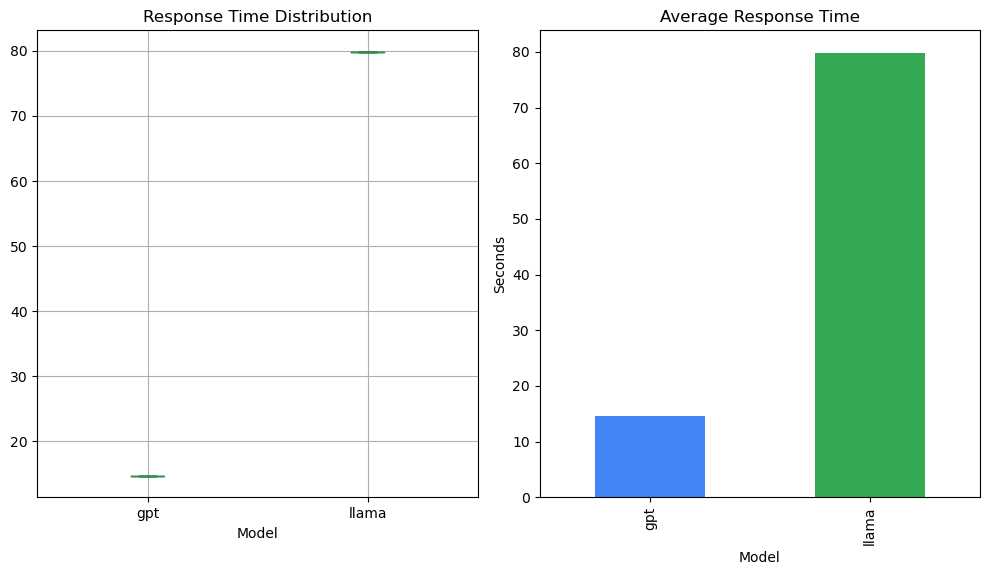

In [22]:

# Show performance metrics
tutor.show_performance_metrics()


In [23]:

# Save history to a file
tutor.save_history("my_tutor_session.json")


History saved to my_tutor_session.json

In [24]:
# Define a new question
new_question = "Explain how to implement a binary search algorithm in Python."

console.print(Panel(f"[bold]New Question:[/bold]\n{new_question}", border_style="green"))

# Get responses for the new question
new_responses = tutor.ask(new_question)

# Compare responses
tutor.compare_responses()


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ New Question:                                                                                                   │
│ Explain how to implement a binary search algorithm in Python.                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Getting response from gpt-4o-mini...                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Binary search is an efficient algorithm for finding a target value within a sorted list. It works by repeatedly dividing the search interval in half. If the target value is less than the element in the middle of the interval, the search continues on the lower half; otherwise, it continues on the upper half. This process is continued until the target value is found or the search interval is empty.

Here's a detailed explanation and implementation of the binary search algorithm in Python:

### Step-by-Step Implementation

1. **Prerequisites**:
   - Ensure the input list is sorted. Binary search can only be performed on a sorted list.
  
2. **Set Initial Variables**:
   - Define two pointers, `low` and `high`, which represent the starting and ending indices of the search range in the list.

3. **Calculate the Middle Index**:
   - Use the formula `mid = (low + high) // 2` to find the middle index.

4. **Comparison**:
   - Compare the middle element with the target:
     - If the middle element is equal to the target, return the index of the middle element.
     - If the target is less than the middle element, narrow the search to the left half by setting `high = mid - 1`.
     - If the target is greater than the middle element, narrow the search to the right half by setting `low = mid + 1`.

5. **Loop Until the Target is Found or the Interval is Empty**:
   - Repeat the above steps until the `low` pointer exceeds the `high` pointer. If the target is not found, return a value indicating that the target is not present (commonly -1).

### Implementation in Python

Here’s a complete Python implementation of the binary search algorithm:


def binary_search(arr, target):
    low = 0
    high = len(arr) - 1

    while low <= high:
        # Find the middle index
        mid = (low + high) // 2
        
        # Check if the target is present at mid
        if arr[mid] == target:
            return mid  # Target found, return the index
        
        # If the target is smaller than the mid element,
        # it can only be present in the left subarray
        elif arr[mid] > target:
            high = mid - 1
        
        # If the target is larger than the mid element,
        # it can only be present in the right subarray
        else:
            low = mid + 1

    # Target was not found
    return -1


### Example Usage


# Example sorted list
arr = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
target = 7

# Perform binary search
result = binary_search(arr, target)

if result != -1:
    print(f'Target {target} found at index {result}.')
else:
    print(f'Target {target} not found in the list.')


### Key Points

1. **Time Complexity**: The time complexity of binary search is O(log n), where n is the number of elements in the array. This is significantly more efficient than a linear search, which has a time complexity of O(n).
  
2. **Space Complexity**: The space complexity of the binary search algorithm is O(1) for the iterative version, as it requires a fixed amount of space for variables.

3. **Iterative vs Recursive**: The above implementation is iterative, which is generally preferred for binary search due to its efficiency and avoidance of recursion limits. However, a recursive implementation can also be done:

### Recursive Implementation


def binary_search_recursive(arr, target, low, high):
    if low <= high:
        mid = (low + high) // 2
        
        if arr[mid] == target:
            return mid
        elif arr[mid] > target:
            return binary_search_recursive(arr, target, low, mid - 1)
        else:
            return binary_search_recursive(arr, target, mid + 1, high)
    
    return -1


### Conclusion

Binary search is a fundamental searching technique that exploits the properties of sorted arrays. Its efficiency makes it a preferred method for searching when working with large datasets. Understanding its underlying algorithm and being able to implement it in Python is a valuable skill in software engineering and data science.

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Getting response from llama3.2...                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## llama3.2 Response
**Implementing Binary Search Algorithm in Python**
=====================================================

Binary search is an efficient algorithm for finding an item from a sorted list of items. It works by repeatedly dividing in half the portion of the list that could contain the item, until you've narrowed down the possible locations to just one.

Here's a step-by-step guide on how to implement binary search in Python:

**Step 1: Define the Search Function**
-------------------------------------

```python
def binary_search(arr, target):
    """
    Searches for an element in a sorted array using binary search algorithm.
    
    Parameters:
    arr (list): The sorted list of elements.
    target: The element to be searched.
    
    Returns:
    int: The index of the target element if found; otherwise, -1.
    """
```

**Step 2: Initialize Variables**
---------------------------------

```python
    low = 0  # Index of the first element in the list
    high = len(arr) - 1  # Index of the last element in the list
```

**Step 3: Loop Until Found or Not Found**
-----------------------------------------

```python
    while low <= high:
        mid = (low + high) // 2  # Calculate the middle index
        
        if arr[mid] == target:
            return mid  # Target found, return its index
        
        elif arr[mid] < target:
            low = mid + 1  # Search in the right half
            
        else:
            high = mid - 1  # Search in the left half
```

**Step 4: Handle Edge Cases**
---------------------------

```python
    if low > high:
        return -1  # Target not found, return -1
```

**Putting it all Together**
-----------------------------

Here's the complete binary search implementation in Python:

```python
def binary_search(arr, target):
    """
    Searches for an element in a sorted array using binary search algorithm.
    
    Parameters:
    arr (list): The sorted list of elements.
    target: The element to be searched.
    
    Returns:
    int: The index of the target element if found; otherwise, -1.
    """
    low = 0
    high = len(arr) - 1

    while low <= high:
        mid = (low + high) // 2
        
        if arr[mid] == target:
            return mid
        elif arr[mid] < target:
            low = mid + 1
        else:
            high = mid - 1
    
    return -1

# Example usage
arr = [2, 4, 6, 8, 10]
target = 6
index = binary_search(arr, target)
if index != -1:
    print(f"Target {target} found at index {index}")
else:
    print("Target not found")
```

**Time Complexity**
------------------

The time complexity of binary search is O(log n), where n is the length of the input array. This makes it much faster than linear search (O(n)) for large datasets.

I hope this explanation helps! Let me know if you have any further questions or need additional clarification.